# Dimension measurement with landmarks
![Alt text](imgs/Measurement_Process.png "Measurement Process")

### General idea
The object dimension measurement approach proposed here defines the problem setting as a regression problem in which a neural network learns to predict specific measurement points (length, width, height) per object type in a supervised setting which requires to label the measurement points per object type before model training. The detected measurement points in pixel space can then be used to execute a perspective transformation of the required object faces/sides for accurate dimension measurement. This example uses boxes as the object to measure. The following steps define the proposal in more detail. 

---

### 1 Model training steps
#### 1.1 Dataset generation and augmentation
The dataset generation and augmentation preparation step uses images (.data/images - jpg) of boxes for which the measurement points (.data/labels - in this example the edges) are labeled (x,y coordinates in pixel space) and documented in a csv-file per box image.
Pytorch DataLoader's in the neural network training phase leverage the AugmentedObjectDataset class to generate an augmented box pictures and labels dataset (train/test) as tensors. See the preprocess method of the AugmentedObjectssDataset class for augmentation details.
#### 1.2 Neural network model training
To detect the required measurement points per object type a neural network based approach is proposed to achieve high detection generalization in a dynamic environment (dust, changing light conditions, non-accurate object positioning on the conveyor belt, etc.). This example leverages a transfer learning approach in which a pre-trained ResNet-18 Pytorch model is used as the base. The output layer is changed to 16 output neurons which translate to 8 measurement points (x, y) per box - in this example the box edges - in the following order:
![Alt text](imgs/Network_Output_Tensor.png "Output Tensor")

This output corresponds to the labeled measurement points ordering in the ./data/labels csv-files.

Since ResNet is a CNN based neural network architecture the model training should be executed on GPU-accelerated instance types like AWS EC2 P2 or P3 for reduced training time.

The neural network output in this example doesn't provide the box type classification which is required for step 2.5 Acceptance evaluation. Enhancing the neural network output with #neurons according to the different box types needs to be implemented as an extension.

---

### 2 Model inference steps
#### 2.1 Image input
The input image should present at best a perspective view on the box sides (front, top, left or right) so that a width/length/height measurement point detection is possible with a single image. This is no fixed requirement and can change depending on the environment and requirements.

#### 2.2 Detect measurement points
The neural network trained on the labeled measurement points tries to predict the measurement points per box type in the input image and outputs a 1x16 Tensor including the x,y measurement point coordinates in normalized pixel space (-1, 1) which needs to be denormalized according to the input image dimensions for perspective warp or optional drawing of the measurement point in the image. 

#### 2.3 Perspective warp
The perspective warping step aims to warp from a 3D perspective view of the box sides to a 2D "bird's eye" view of each box side of interest for accurate dimension measurement in pixel space. For the perspective warping OpenCV provides native methods like warpPerspective which leverages the predicted measurements points of the neural network. The output of the perspective warping step is a warped 2D view of the front, top, left or right side of the box. 

#### 2.4 Dimension measurement
The dimension measurement needs to be done per box side after the warping step according to the predicted measurement points. The measurement is first done in pixel space and needs to be converted into metric space depending on factors like camera distance or sensor dimension.

#### 2.5 Acceptance evaluation
According to the measurement dimensions an acceptance evaluation step must be done to decide if the dimensions per box are in a valid range or if the box is not acceptable. The measurement accuracy (e.g. in mm) depends a lot on factors like camera positioning, sensor quality, environmental noise in addition to the predictive performance of the approach model presented here. If a single camera setup is not sufficient because of missing view of box sides the model should be able to generalize the measurement point prediction in a multi camera setup each running the same trained model. A consolidation step of the multiple measurements must be taken into consideration.

---

In [ ]:
!pygmentize code/dataset.py

In [ ]:
%%writefile code/train.py
import torch
import torch.nn as nn
import torchvision.models as models
import os
import argparse
import time
from dataset import AugmentedObjectsDataset

def train_epoch(optimizer, criterion, epoch, model, train_dataloader, test_dataloader):
    train_loss = 0.0    
    test_loss = 0.0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model.train()
    for x_train, y_train in train_dataloader:
        x_train,y_train = x_train.to(device),y_train.to(device)        
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()
        # prediction for training and validation set        
        output_train = model(x_train)
        loss_train = criterion(output_train, y_train)              
        # computing the updated weights of all the model parameters
        # statistics
        train_loss += loss_train.item()
        loss_train.backward()
        optimizer.step()        
    
    model.eval()
    for x_test, y_test in test_dataloader:            
        x_test,y_test = x_test.to(device),y_test.to(device)
        output_test = model(x_test.float())
        loss_test = criterion(output_test, y_test)
        # statistics
        test_loss += loss_test.item()                
        
    return train_loss, test_loss


def train(args):
    best_of_the_best = (0,-1)
    best_loss = 10000000
    learning_rates = [args.lr / max(1.0, args.lr_decay * float(i)) for i in range(args.iterations)]
    num_epochs=[args.epochs + (i*args.epochs_step) for i in range(args.iterations)]
    batch_size = args.batch_size
    dataset_path= args.train
    num_landmarks=8    
    output_data_dir=args.intermediate_dir
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    max_samples=args.max_samples
    train_samples=int(max_samples*.7)
    test_samples=int(max_samples*.3)
    
    os.makedirs(output_data_dir, exist_ok=True)
    
    criterion = nn.MSELoss()    

    train_dataloader = torch.utils.data.DataLoader(AugmentedObjectsDataset(dataset_path,train_samples), batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(AugmentedObjectsDataset(dataset_path,test_samples), batch_size=batch_size)

    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_landmarks*2, bias=True)
    state_path = os.path.join(output_data_dir, "best_state.pth")
    if os.path.exists(state_path):
        model.load_state_dict(torch.load(state_path))
    model.to(device)

    # Instantiate model
    # Training loop
    for num_iterations, learning_rate in zip(num_epochs, learning_rates):
        print(f'Starting training... epoch iterations: {num_iterations} lr: {learning_rate}')
        for epoch in range(num_iterations):
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            start_time = time.time()
            train_loss, test_loss = train_epoch( optimizer, criterion, epoch, model, train_dataloader, test_dataloader)
            elapsed_time = (time.time() - start_time)
            print("epoch=%d; train_loss=%.3f; test_loss=%.3f; elapsed_time=%.3fs" % (epoch, train_loss, test_loss, elapsed_time))
            if test_loss < best_loss:                
                torch.save(model.state_dict(), os.path.join(output_data_dir,'best_state.pth'))
                best_loss = test_loss
                if best_loss < best_of_the_best[0]:
                    best_of_the_best = (best_loss, i)
    print("\nBest model: best_mse=%f;" % best_loss)

    model.load_state_dict( torch.load(os.path.join(output_data_dir, "best_state.pth")) )    
    inp = torch.rand(1, 3, 416, 416).to(device)
    model_trace = torch.jit.trace(model, inp)
    model_trace.save( os.path.join(args.model_dir, "model.pth") )

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--max-samples', type=int, default=1000, help='Number of dynamic samples')
    parser.add_argument('--model-dir', type=str, default=os.environ["SM_MODEL_DIR"], help='Trained model dir')
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--num-gpus', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--intermediate-dir', type=str, default=os.environ['SM_OUTPUT_INTERMEDIATE_DIR'])
    parser.add_argument('--batch-size', type=int, default=30)
    
    parser.add_argument('--epochs', type=int, default=30, help='Initial num epochs')
    parser.add_argument('--epochs-step', type=int, default=30, help='How many epochs we need to try in the next iter')
    parser.add_argument('--iterations', type=int, default=4, help='Number of epoch iterations')
    
    parser.add_argument('--lr', type=float, default=0.001, help='Learning rates')
    parser.add_argument('--lr-decay', type=int, default=10, help='Learning rate decay per epoch round')
    
    args,unknown = parser.parse_known_args()

    train(args)
# test string
#!SM_MODEL_DIR=/tmp SM_CHANNEL_TRAIN=$PWD/data SM_NUM_GPUS=1 SM_OUTPUT_INTERMEDIATE_DIR=/tmp/out \
#    python3 code/train.py --batch-size 30

In [ ]:
import sagemaker
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'dimension-measurement-with-landmarks'

### Download the images & upload the dataset

In [ ]:
import urllib.request
import os
for url in open('resources/Image_Source_URLs.txt', 'r').readlines():
    url = url.strip()
    urllib.request.urlretrieve(url, os.path.join('data', url.split('/')[-1]))

In [ ]:
# Upload data (images, labels) to S3
dataset_path = sess.upload_data(path="data", key_prefix=f"{prefix}/data")
print(dataset_path)

In [ ]:
from sagemaker.pytorch.estimator import PyTorch

pytorch_estimator = PyTorch(
    entry_point="train.py",
    source_dir="code",
    framework_version='1.7',
    py_version='py36',
    instance_count=1,
    role=role,
    instance_type="ml.p3.2xlarge",    
    hyperparameters={
        'batch-size': 36,
        'max-samples': 1000,
        'epochs': 30,
        'epochs-step': 30,
        'iterations': 5,
        'lr': 0.001
    },
    metric_definitions=[
        {'Name': 'train_loss:mse', 'Regex': ' train_loss=(\S+);'},
        {'Name': 'test_loss:mse', 'Regex': ' test_loss=(\S+);'}
    ]
)

In [ ]:
# For logs see the training job within SageMaker console
pytorch_estimator.fit({"train": dataset_path})

In [ ]:
import time
import boto3

sm_client = boto3.client('sagemaker')

# Change the target OS + Arch depending on the device you'll run this application
os='LINUX'
arch='X86_64' # ARM64
model_name='dimension-measurement'
filename=f'model-{os}_{arch}.tar.gz'

compilation_job_name = f'{model_name}-{int(time.time()*1000)}'

s3_uri=f'{pytorch_estimator.output_path}{pytorch_estimator.latest_training_job.name}/output/model.tar.gz'
s3_uri_out=f's3://{sess.default_bucket()}/{model_name}-tensorflow/optimized'
s3_uri_out_path=f"{s3_uri_out}/{filename}"

sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': s3_uri,
        'DataInputConfig': '{"input":[1,3,416,416]}',
        'Framework': 'PYTORCH'
    },
    OutputConfig={
        'S3OutputLocation': s3_uri_out,
        'TargetPlatform': { 
            'Os': os, 
            'Arch': arch, 
            #'Accelerator': 'NVIDIA' 
        },
        #'CompilerOptions': '{"trt-ver": "7.1.3", "cuda-ver": "10.2", "gpu-code": "sm_53"}' # Jetpack 4.4.1
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 900 }
)
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(5)


### 2.1 Model inference

In [ ]:
!aws s3 cp $s3_uri_out_path /tmp/
!rm -rf model_neo && mkdir model_neo
!tar -xzvf /tmp/$filename -C model_neo

In [ ]:
# install DLR, the runtime required to load the model
!pip install -U dlr==1.8.0

In [ ]:
import dlr
try:
    model = dlr.DLRModel('model_neo', 'cpu')
except Exception as e:
    print(e)

In [15]:
import glob
import numpy as np
from PIL import Image

def load_image(img_path, img_side=416):
    img = Image.open(img_path).convert('RGB')
    w,h = img.size
    if w!=h:
        img_side_max=max(w,h)
        img_pad = Image.new('RGB', (img_side_max, img_side_max), (0,0,0))
        img_pad.paste(img, img.getbbox())  # Not centered, top-left corner        
        img = img_pad
    img = img.resize((img_side, img_side), resample=Image.BILINEAR)
    x = (np.array(img) / 255.0).astype(np.float32)
    # normalize image
    x -= [0.485, 0.456, 0.406]
    x /= [0.229, 0.224, 0.225]
    x = x.transpose(2,0,1) # HWC --> CHW
    return x.reshape(1, 3, img_side, img_side), np.array(img)

In [16]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(5)
viridis = cm.get_cmap('viridis', 10)
colors = [(np.array(viridis(np.random.rand(1)[0])[:-1])*255).astype(int).tolist() for i in range(8)]


def plot_prediction(img, y, img_side=416):
    img_with_points = np.array(img)
    h,w,c = img.shape
    #fh,fw = np.array((h,w), dtype=np.float32) / (img_side,img_side)
    fh,fw=1.0,1.0
    for i,p in enumerate(y.reshape(8,2)):
        if (p > (0,0)).all():            
            p = ((p * (img_side, img_side)) * (fw,fh) ).astype(np.int32)            
            cv2.circle(img_with_points, tuple(p), w//300, (255,0,255), cv2.FILLED)
            cv2.putText(img_with_points, str(i), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, w//350, colors[i], w//200, cv2.LINE_AA)
    plt.figure(figsize=(15,10))
    plt.imshow(img_with_points)

(1, 3, 416, 416)


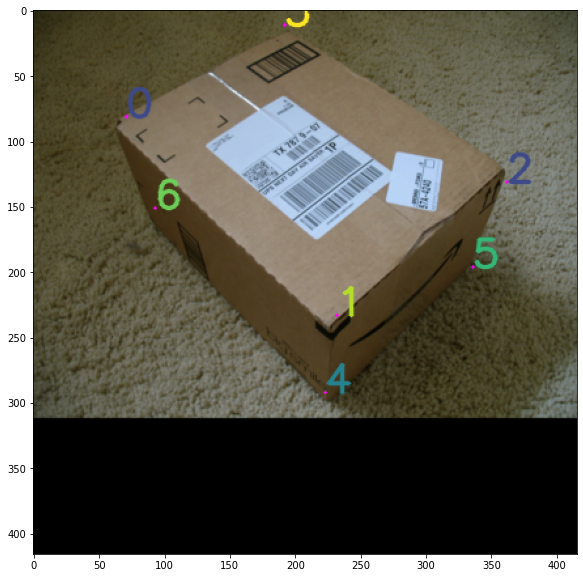

In [46]:
%matplotlib inline
images = glob.glob('data/*.jpg')
image_name=images[np.random.randint(0,len(images))]
x, img = load_image(image_name)
print(x.shape)
y = model.run(x)
plot_prediction(img, y[0])

### 2.2 Detect Measurement Points

### 2.3 Perspective Warp
This example just shows warping for the top side of on example box which allows you to measure length and width. Left, right or front side perspective warp is required to measure the box height.

In [51]:
# Takes the 8x2 measurement point tensor as input e.g. ground truth or NN output and return the measurement points per side
# This needs to be adjusted according to the camera setup and the perspective view on the box
def get_points_per_side(input_tensor):
    points_per_side = {
        'top_side' : {
            'upper_left' : (input_tensor[0][0], input_tensor[0][1]),
            'lower_left' : (input_tensor[1][0], input_tensor[1][1]),
            'lower_right' : (input_tensor[2][0], input_tensor[2][1]),
            'upper_right' : (input_tensor[3][0], input_tensor[3][1])
        },
        'front_side' : {
            'upper_left' : (input_tensor[1][0], input_tensor[1][1]),
            'lower_left' : (input_tensor[4][0], input_tensor[4][1]),
            'lower_right' : (input_tensor[5][0], input_tensor[5][1]),
            'upper_right' : (input_tensor[2][0], input_tensor[2][1])

        },
        'outer_side_right' : {
            'upper_left' : (input_tensor[2][0], input_tensor[2][1]),
            'lower_left' : (input_tensor[5][0], input_tensor[5][1]),
            'lower_right' : (input_tensor[7][0], input_tensor[7][1]),
            'upper_right' : (input_tensor[3][0], input_tensor[3][1])
        },
#        'outer_side_left' : {
#            'upper_left' : (input_tensor[0][0], input_tensor[0][1]),
#            'lower_left' : (input_tensor[6][0], input_tensor[6][1]),
#            'lower_right' : (input_tensor[4][0], input_tensor[4][1]),
#             'upper_right' : (input_tensor[1][0], input_tensor[1][1])
#        }
    }
    return points_per_side


In [23]:
def get_length_width(tl, tr, br, bl):
    lengthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    lengthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    # ...and now for the width of our new image
    widthA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    widthB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    # take the maximum of the length and width values to reach
    # our final dimensions
    # this example takes the edges as measurement points and may need to be adapted
    max_length = max(int(lengthA), int(lengthB))
    max_width = max(int(widthA), int(widthB))

    return max_length, max_width
    
def create_warped_image(points, max_length, max_width, img):
    # Create point matrix
    point_matrix = np.float32([points['upper_left'], points['upper_right'], points['lower_right'], points['lower_left']])
    
    # construct our destination points which will be used to
    # map to a top-down, "birds eye" view
    dst = np.array([
        [0, 0],
        [max_length, 0],
        [max_length, max_width],
        [0, max_width]], dtype = "float32")

    # calculate the perspective transform matrix and warp the perspective
    M = cv2.getPerspectiveTransform(point_matrix, dst)
    warp = cv2.warpPerspective(img, M, (max_length, max_width))
    return warp#, length_in_pixel, width_in_pixel

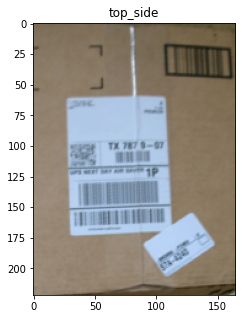

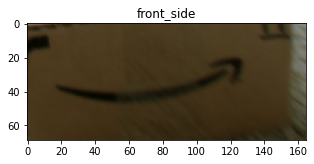

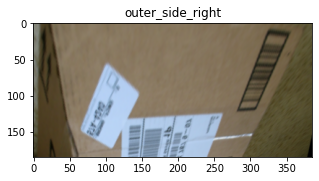

In [47]:
h,w,c=img.shape
landmarks = y[0].reshape(8,2) * (w,h)

# Warp image per side (top, front, outer_right) from NN output
measurements_per_side = {}
for side, points in get_points_per_side(landmarks).items():
    length, width = get_length_width(points['upper_left'], points['upper_right'], points['lower_right'], points['lower_left'])
    img_warped = create_warped_image(points, length, width, img.copy())
    measurements_per_side[side] = (length, width) 
    plt.figure(figsize=(5,5))
    plt.title(side)
    plt.imshow(img_warped)

### 2.4 Dimension Measurement
For the dimension measurement part there needs to be a mechanism in place which allows us to translate from pixel space to metric space for later acceptance evaluation since we're operating in pixel space until this point. In this example we're assuming that there is a 1:1 relationship between pixel and metric space e.g. 1px = 1mm. Depending on the use case and environmental factors like camera distance to object or camera sensor resolution this ratio needs to be adjusted accordingly.

In [29]:
def pixels_to_metric(pixel_length, pixel_width, pixel_to_metric_ratio=1):
    metric_length = pixel_length * pixel_to_metric_ratio
    metric_width = pixel_width * pixel_to_metric_ratio
    return (metric_length, metric_width)

In [30]:
def acceptance_evaluation(measurement, ground_truth, tolerance):
    evaluation_result = {}
    for side, dimension in ground_truth.items():
        gt_length, gt_width = dimension[0], dimension[1]
        m_length, m_width = measurement[side][0], measurement[side][1]
        evaluation_result[side] = {'length' : abs(gt_length - m_length) <= tolerance[side]['length'],
                                   'width' : abs(gt_width - m_width) <= tolerance[side]['width']}
    for side, result in evaluation_result.items():
        if not result['length']:
            print('Measurement {} length not in tolerance'.format(side))
        if not result['width']:
            print('Measurement {} width not in tolerance'.format(side))
    return evaluation_result    

### 2.5 Acceptance Evaluation

In [52]:
# Reading the ground truth measurement points for a specific image (brick02.jpg)
h_original,w_original,_ = cv2.imread(image_name).shape
ground_truth = np.fromfile(image_name.replace('.jpg', '.csv'), dtype=np.int32, sep=',').reshape((8,2))
ground_truth = (ground_truth / (w_original,h_original)) * (416,416)
metric_gt_per_side = {}
metric_unit = 'mm'
metric_measurement_per_side = {}

# depending on the perspective view the sides may change in this dict
# in mm
dimension_tolerance = {
    'top_side' : {
        'length' : 0.5,
        'width' : 0.5,
    },
    'front_side' : {
        'length' : 1.5,
        'width' : 0.5,
    },
    'outer_side_right' : {
        'length' : 0.5,
        'width' : 0.5,
    },
#     'outer_side_left' : {
#         'x' : 155.0,
#         'y' : 150.0,
#     }
}

for side, points in get_points_per_side(ground_truth).items():
    length, width = get_length_width(points['upper_left'], points['upper_right'], points['lower_right'], points['lower_left'])
    metric_gt_per_side[side] = pixels_to_metric(length, width)
    
for side, measurement in measurements_per_side.items():
    length, width = pixels_to_metric(measurement[0], measurement[1])
    metric_measurement_per_side[side] = (length, width)
    print("Measurement {} length: {:7.4f} {}".format(side, length, metric_unit))
    print("Measurement {} width: {:7.4f} {}".format(side, width, metric_unit))
    print()
    
for side, gt in metric_gt_per_side.items():
    length, width = pixels_to_metric(gt[0], gt[1])
    print("Ground truth {} length: {:7.4f} {}".format(side, length, metric_unit))
    print("Ground truth {} width: {:7.4f} {}".format(side, width, metric_unit))
    print()

result = acceptance_evaluation(metric_measurement_per_side, metric_gt_per_side, dimension_tolerance)

Measurement top_side length: 165.0000 mm
Measurement top_side width: 222.0000 mm

Measurement front_side length: 165.0000 mm
Measurement front_side width: 69.0000 mm

Measurement outer_side_right length: 386.0000 mm
Measurement outer_side_right width: 185.0000 mm

Ground truth top_side length: 206.0000 mm
Ground truth top_side width: 261.0000 mm

Ground truth front_side length: 206.0000 mm
Ground truth front_side width: 100.0000 mm

Ground truth outer_side_right length: 424.0000 mm
Ground truth outer_side_right width: 195.0000 mm

Measurement top_side length not in tolerance
Measurement top_side width not in tolerance
Measurement front_side length not in tolerance
Measurement front_side width not in tolerance
Measurement outer_side_right length not in tolerance
Measurement outer_side_right width not in tolerance


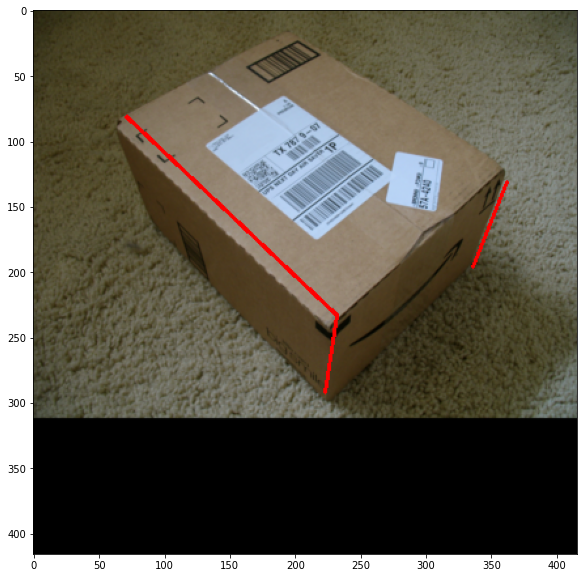

In [53]:
for side, points in get_points_per_side(landmarks).items():
    length_color = (0, 255, 0) if result[side]['length'] else (255, 0, 0) 
    width_color = (0, 255, 0) if result[side]['width']  else (255, 0, 0)
    
    img_with_points = cv2.line(img.copy(), 
                               (int(points['upper_left'][0]),int(points['upper_left'][1])), 
                               (int(points['upper_right'][0]), int(points['upper_right'][1])), length_color, 2)
    img_with_points = cv2.line(img, 
                               (int(points['upper_left'][0]),int(points['upper_left'][1])), 
                               (int(points['lower_left'][0]), int(points['lower_left'][1])), width_color, 2)
plt.figure(figsize=(15,10))
plt.imshow(img_with_points)